# 学習方法の例

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from common.layers import TwoLayerNet
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.patheffects as pe
import matplotlib.ticker as ticker
import matplotlib.colors

In [2]:
from collections import OrderedDict
from common.layers import Convolution, MaxPooling, ReLU, Affine, SoftmaxWithLoss
from common.optimizer import RMSProp

In [3]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 pool_param={'pool_size':2, 'pad':0, 'stride':2},
                 hidden_size=100, output_size=15, weight_init_std=0.01):
        """
        input_size : tuple, 入力の配列形状(チャンネル数、画像の高さ、画像の幅)
        conv_param : dict, 畳み込みの条件
        pool_param : dict, プーリングの条件
        hidden_size : int, 隠れ層のノード数
        output_size : int, 出力層のノード数
        weight_init_std ： float, 重みWを初期化する際に用いる標準偏差
        """
                
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        
        pool_size = pool_param['pool_size']
        pool_pad = pool_param['pad']
        pool_stride = pool_param['stride']
        
        input_size = input_dim[1]
        conv_output_size = (input_size + 2*filter_pad - filter_size) // filter_stride + 1 # 畳み込み後のサイズ(H,W共通)
        pool_output_size = (conv_output_size + 2*pool_pad - pool_size) // pool_stride + 1 # プーリング後のサイズ(H,W共通)
        pool_output_pixel = filter_num * pool_output_size * pool_output_size # プーリング後のピクセル総数
        
        # 重みの初期化
        self.params = {}
        std = weight_init_std
        self.params['W1'] = std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b1'] = np.zeros(filter_num) #b1は畳み込みフィルターのバイアスになる
        self.params['W2'] = std *  np.random.randn(pool_output_pixel, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = std *  np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU1'] = ReLU()
        self.layers['Pool1'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['ReLU2'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    
    def predict_label(self, x):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        return y

    def loss(self, x, t):
        """
        損失関数
        x : 入力データ
        t : 教師データ
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝播法）
        Parameters
        ----------
        x : 入力データ
        t : 教師データ
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

## データを読む1

In [4]:
train_data = np.load("../1_data/train_data_w_pre_prcss.npy")
train_label = np.load("../1_data/train_label_w_pre_prcss.npy")
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data.shape= (2617, 1, 28, 28)
train_label.shape= (2617, 15)


In [5]:
# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')
# print(train_data)

In [6]:
# 配列形式変更
train_data = train_data.reshape(-1, 28*28)
print("train_data.shape=", train_data.shape)

train_data.shape= (2617, 784)


## trainとtestに分割する

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, 
                                                                                        test_size=0.3, random_state=1234,
                                                                                        shuffle=True
                                                                                       )

print(X_train.shape, X_test.shape)

(1831, 784) (786, 784)


## 学習

In [ ]:
# epochs = 10
# batch_size = 32
# lr = 0.01

# # 繰り返し回数
# xsize = X_train.shape[0]
# iter_num = np.ceil(xsize / batch_size).astype(np.int)

# # 2層NNのオブジェクト生成
# tnet = TwoLayerNet(input_size=28*28, hidden_size=10, output_size=15)

# train_loss = []
# test_loss = []
# train_accuracy = []
# test_accuracy = []
# for epoch in range(epochs):
#     print("epoch=%s"%epoch)
    
#     # シャッフル
#     idx = np.arange(xsize)
#     np.random.shuffle(idx)

#     for it in range(iter_num):
#         """
#         ランダムなミニバッチを順番に取り出す
#         """
#         mask = idx[batch_size*it : batch_size*(it+1)]
    
#         # ミニバッチの生成
#         x_ = X_train[mask]
#         y_ = y_train[mask]
        
#         # 勾配の計算
#         grads = tnet.gradient(x_, y_)

#         # パラメータの更新
#         for key in tnet.params.keys():
#     #         print(key)
#             tnet.params[key] -= lr * grads[key]

#     ## 学習経過の記録
    
#     # 訓練データにおけるloss
#     train_loss.append(tnet.loss(X_train,  y_train))
    
#     # テストデータにおけるloss
#     test_loss.append(tnet.loss(X_test, y_test))
    
#     # 訓練データにて精度を確認
#     train_accuracy.append(tnet.accuracy(X_train, y_train))

#     # テストデータにて精度を算出
#     test_accuracy.append(tnet.accuracy(X_test, y_test))

epoch=0
epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9


In [8]:
# x = train[:1000,:]
# t = train_labels[:1000,:]

x = X_train
t = y_train
test = X_test
test_labels = y_test

x = x.reshape(-1,1,28,28) # 配列形式の変形
test = test.reshape(-1,1,28,28) # 配列形式の変形

epochs = 10
batch_size = 100

optimizer = RMSProp(lr=0.01, rho=0.9)

# 繰り返し回数
xsize = x.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)


# CNNのオブジェクト生成
snet = SimpleConvNet(input_dim=(1, 28, 28), 
                     conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                     pool_param={'pool_size':2, 'pad':0, 'stride':2},
                     hidden_size=100, output_size=15, weight_init_std=0.01)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

test_pred = []

for epoch in range(epochs):
    print("epoch=%s"%epoch)

    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        """
        ランダムなミニバッチを順番に取り出す
        """
        print("it=", it)
        mask = idx[batch_size*it : batch_size*(it+1)]

        # ミニバッチの生成
        x_train = x[mask]
        t_train = t[mask]

        # 勾配の計算 (誤差逆伝播法を用いる) 
        grads = snet.gradient(x_train, t_train)

        # 更新
        optimizer.update(snet.params, grads)

    ## 学習経過の記録

    # 訓練データにおけるloss
#     print("calculating train_loss")    
    train_loss.append(snet.loss(x,  t))

#     print("calculating test_loss")
    # テストデータにおけるloss
    test_loss.append(snet.loss(test, test_labels))

#     print("calculating train_accuracy")
    # 訓練データにて精度を確認
    train_accuracy.append(snet.accuracy(x, t))
    
#     print("calculating test_accuracy")
    # テストデータにて精度を算出
    test_accuracy.append(snet.accuracy(test, test_labels))
    
    # テストデータの推論結果
    test_pred.append(snet.predict_label(test))

/tmp/ipykernel_8158/2920069429.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iter_num = np.ceil(xsize / batch_size).astype(np.int)


epoch=0
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
epoch=1
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
epoch=2
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
epoch=3
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
epoch=4
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
epoch=5
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
epoch=6
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
epoch=7
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
i

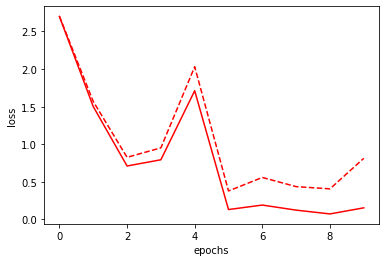

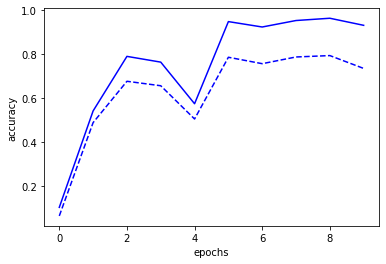

In [10]:
x_epoch = np.arange(0, 10, 1)

plt.plot(x_epoch, train_loss, 'r-')
plt.plot(x_epoch, test_loss, 'r--')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

plt.plot(x_epoch, train_accuracy, 'b-')
plt.plot(x_epoch, test_accuracy, 'b--')
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.show()

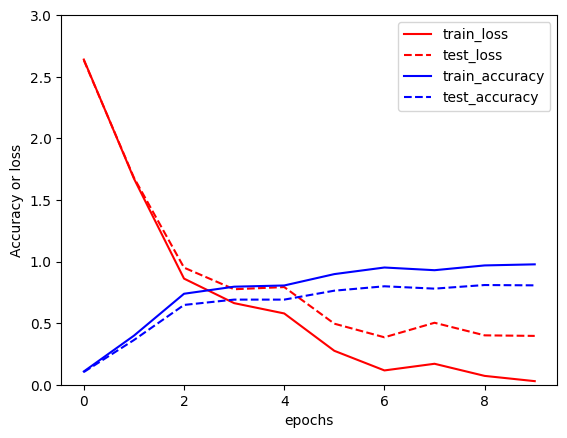

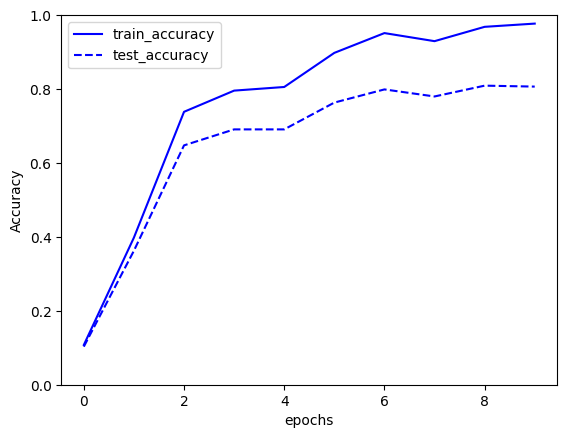

In [9]:
# lossとaccuracyのグラフ化
df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
             "train_accuracy":train_accuracy,
             "test_accuracy":test_accuracy})

df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
plt.ylim([0,3])
plt.ylabel("Accuracy or loss")
plt.xlabel("epochs")
plt.show()

# accuracyのグラフ化
df_log = pd.DataFrame({"train_accuracy":train_accuracy,
             "test_accuracy":test_accuracy})

df_log.plot(style=['b-', 'b--'])
plt.ylim([0,1])
plt.ylabel("Accuracy")
plt.xlabel("epochs")
plt.show()


## 学習済みモデルの出力

In [10]:
with open("katakana_model_r01.pickle", "wb") as f:
    pickle.dump(snet, f)

データの可視化

In [10]:
print(test_labels.shape)

(786, 15)


In [ ]:
print(test_labels[0])

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


In [ ]:
print(type(test_labels[0]))

<class 'numpy.ndarray'>


In [11]:
vec_trans_id = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
print(vec_trans_id)

test_id = np.dot(test_labels[0], vec_trans_id.T)
print(test_id)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
2


In [12]:
test_id = np.dot(test_labels, vec_trans_id.T)
print(test_id.shape)
print(test_id)
# test_id_pred = np.dot(test_pred, vec_trans_id.T)
# print(test_id_pred.shape)

(786,)
[ 2  6 14  9 11  8 12  0 11 12 10  6  9  5  2  3 14 14  1  6  4  6 14  5
 13  2  7  5  7  3  2 12 11  2  2  9 13  0  5  3  5  5  6  2 10  6  7  3
  0  3 12  7  6  6  2 14  2 11 10  6  0  6  7  1  4  6 10  8 11 10  1 11
  1  7 12  3  0  6  8 13  6  3  7  5  6 13  3  9 11 13  9  0  1 13 13 14
  7  7  8  6 11  2  5  0  0  2  1 13  5  7  1  9  7 12  3 13  8  3  3  5
  8  9  0  0 14  5  8  1  7  2  3  5  2 12  1 14 13 13  9  5  8 11  3  6
  0 12 12  0  0  4  8  1  8 12  8  7 13  4  7  3  1  9  7  1 13 11 14  3
 14 13  3  4 12  2  2  7 12  5  1  8 11  0  7  5  9  7 14  9 12  8 14 11
  8  9 10  2 14  7  3  7 10  7  9  2 10 11  9  0  9  8  0 11 14  4  8  5
 13  5  3  4  4 12  0  5 10 12  2  9 12  6  1  0  7 11  2  3 11 13  3 13
  9 13  3  2  9  4  5 14  9  0  9  0 13  2 12  4  0  3  0  4  7 13 10 14
  9  4  0 10  6 10  7  1  2 14  3  8 10 12  3 12 12  3 11  1  9 12 10  5
  1  8  3 10  1  0  0 14  8  7  3  7  9 12  5  8  1  1  5  9  1  6  9  5
 14  2  2  7  1  6  6  3  2 14  3  1  6 10  

In [17]:
print(test_pred[0].shape)
print(test_pred[0])

(900,)
[ 3  5  7  1  7  3  3  3  2  3  7  7  7  3  3  7  2  1  2  5  5  3  7  2
  1  7  1  5  7  7  0 12  1 12  3  5  0  5  1  3  3  1  3  3  5  2  3  5
  1  3  3  1  3  3  7  0  3  7  1  5  5  8  7  5  5  1  2  3  7  5  3  0
  7  1  1  1  0  3  3  3 12  3  1  3  3  5  1  5  1  1  7  3  1  1  7 12
  3  1  5  7  7  5  3  3  0  3 12  3  5  3  3  3 10  7  3  1  1  7  7  1
  3  7  3  0  1  5  7  2  3  3  2  0  1  7  0  3  3  7  0  3  8  3  5  3
  3  1  3 12  0  7  0  1  7  3  3  7  3  3  1  2  5  1  7  3  7  3  0  3
  1  0  7  7  7  3  7  1  3 12  1  7  5  0  1  3  5  5  0 12  3  5  1  3
  7  1  7  1  1  7  2  7  3  7  1  3  1 12  3  7 12  3  3  3  5 12  7  7
  1  0  7  5  1  7  0  5  7  0  5  5  7  7  0  3 12  5  2  7  3  3  7  1
  3  1  1  3  3  5  3  5  0  7  2  5  1  2  2  3  3  1  7  3  3  1  3  3
  3  1  7  3  5  3  8  1  1  7  3  1 12 12  2  5  5  1  3 10  1  7  7  0
 12  1  0  7  7  1  0  5  1 12  5  7  3  3  1  3  7  1 12  5  7  3  5  1
  0  2  1  0  7  5  7  7  3  5  3  0  7  1  

In [13]:
df = pd.DataFrame({'ground_truth':test_id, 'prediction':test_pred[9]})
display(df.head(5))  # 先頭から5行を表示
display(df.tail(5))  # 末尾から5行を表示

,ground_truth,prediction
0,2,2
1,6,6
2,14,14
3,9,9
4,11,11


,ground_truth,prediction
781,5,1
782,9,9
783,14,14
784,7,7
785,14,14


In [14]:
# 「正解」と「予測」が一致していない行を抽出
df2 = df[df['ground_truth']!=df['prediction']]
display(df2.head(5))

# 昇順にソート 第1キー'ground_truth'、第2キー'prediction
df2 = df2.sort_values(['ground_truth', 'prediction'])
display(df2.head(5))

,ground_truth,prediction
19,6,11
29,3,12
41,5,13
45,6,4
50,12,1


,ground_truth,prediction
340,0,1
181,0,3
293,0,8
105,2,5
550,2,5


In [16]:
idn = 19
s = snet.predict( np.array([test[idn]]) ) # 出力層の値
s = s[0]
print( f'予測分類は「{s.argmax()}」で、出力層の対応ニューロンの出力値{s[s.argmax()]:.2f}' ) 
print( f'正解分類は「{test_id[idn]}」で、出力層の対応ニューロンの出力値{s[test_id[idn]]:.2f}' )

予測分類は「11」で、出力層の対応ニューロンの出力値4.33
正解分類は「6」で、出力層の対応ニューロンの出力値2.14


In [35]:
print(test[0].shape)
test_2d = test[0].reshape(28, 28)

print(test_2d.shape)

(1, 28, 28)
(28, 28)


In [37]:
print(test.shape)

(900, 1, 28, 28)


■ 正解値「0」に対して正しく予測（分類）できなかったケース


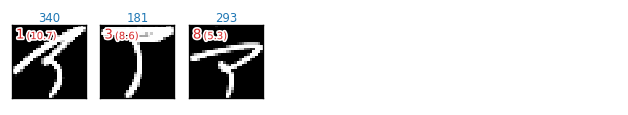

■ 正解値「1」に対して正しく予測（分類）できなかったケース
■ 正解値「2」に対して正しく予測（分類）できなかったケース


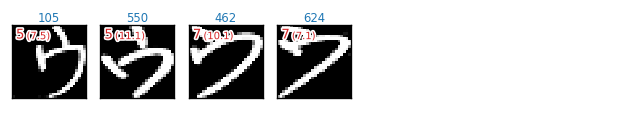

■ 正解値「3」に対して正しく予測（分類）できなかったケース


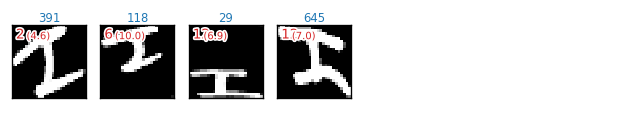

■ 正解値「4」に対して正しく予測（分類）できなかったケース


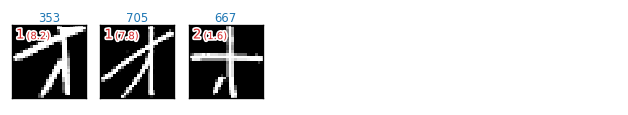

■ 正解値「5」に対して正しく予測（分類）できなかったケース


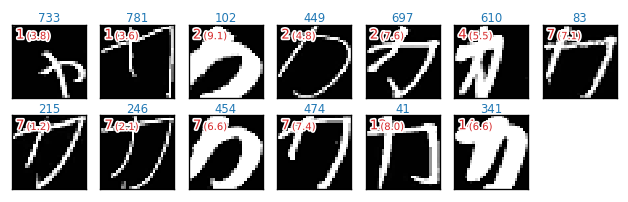

■ 正解値「6」に対して正しく予測（分類）できなかったケース


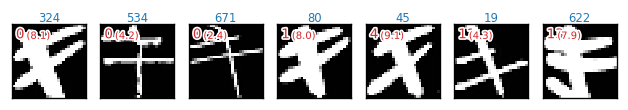

■ 正解値「7」に対して正しく予測（分類）できなかったケース


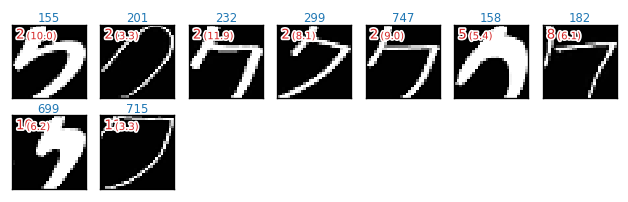

■ 正解値「8」に対して正しく予測（分類）できなかったケース


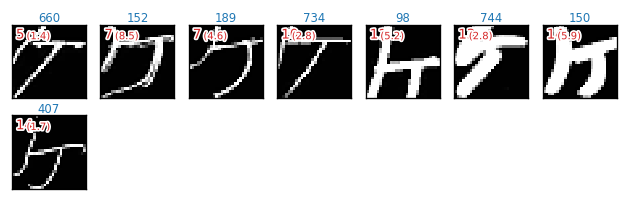

■ 正解値「9」に対して正しく予測（分類）できなかったケース


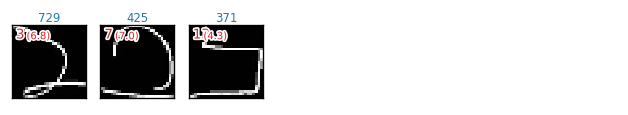

■ 正解値「10」に対して正しく予測（分類）できなかったケース


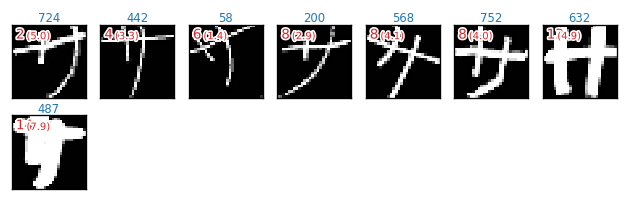

■ 正解値「11」に対して正しく予測（分類）できなかったケース


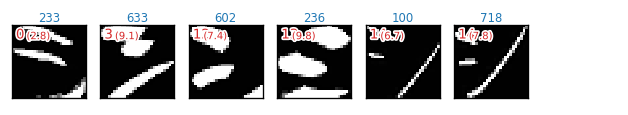

■ 正解値「12」に対して正しく予測（分類）できなかったケース


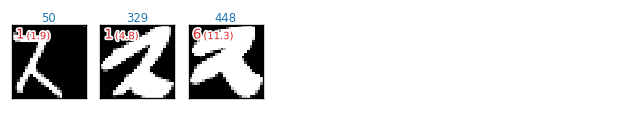

■ 正解値「13」に対して正しく予測（分類）できなかったケース


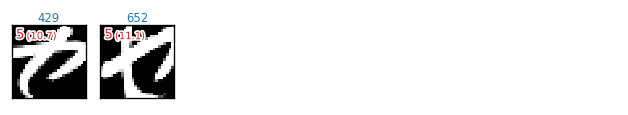

■ 正解値「14」に対して正しく予測（分類）できなかったケース


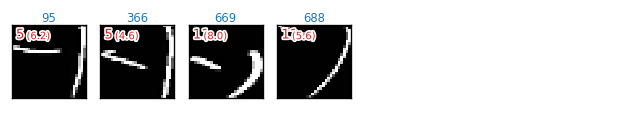

In [21]:
test_image = test.reshape(786, 28, 28) # 各画像を2次元配列にしてmatplotlibが出力できるようにする

s_test = snet.predict( np.array(test) ) # 出力層の値

for t in range(0,15):

  print(f'■ 正解値「{t}」に対して正しく予測（分類）できなかったケース')

  # 正解値が t の行を抽出
  index_list = list(df2[df2['ground_truth']==t].index.values)

  # matplotlib 出力
  n_cols = 7
  n_rows = ((len(index_list)-1)//n_cols)+1
  if n_rows < 1 : continue
  fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6.5, 0.9*n_rows), dpi=120)
  for i,ax in enumerate( np.ravel(ax) ):
    if i < len(index_list):

      p = index_list[i]
      ax.imshow(test_image[p],interpolation='nearest',vmin=0.,vmax=1.,cmap='Greys')

      # 予測（分類）を左上に表示
      t = ax.text(1, 1, f'{test_pred[9][p]}', verticalalignment='top', fontsize=8, color='tab:red')
      t.set_path_effects([pe.Stroke(linewidth=2, foreground='white'), pe.Normal()]) 

      # 予測（分離）に対応する出力層のニューロンの値を括弧で表示
      t = ax.text(5, 2, f'({s_test[p].max():.1f})', verticalalignment='top', fontsize=6, color='tab:red')
      t.set_path_effects([pe.Stroke(linewidth=2, foreground='white'), pe.Normal()]) 

      # 目盛などを非表示に
      ax.tick_params(axis='both', which='both', left=False, labelleft=False, 
                     bottom=False, labelbottom=False)

      # 青色でインデックスを表示
      ax.set_title(index_list[i],fontsize=7,pad=1.5,color='tab:blue')

    else :
      ax.axis('off') # 余白処理

  plt.show()

混同行列

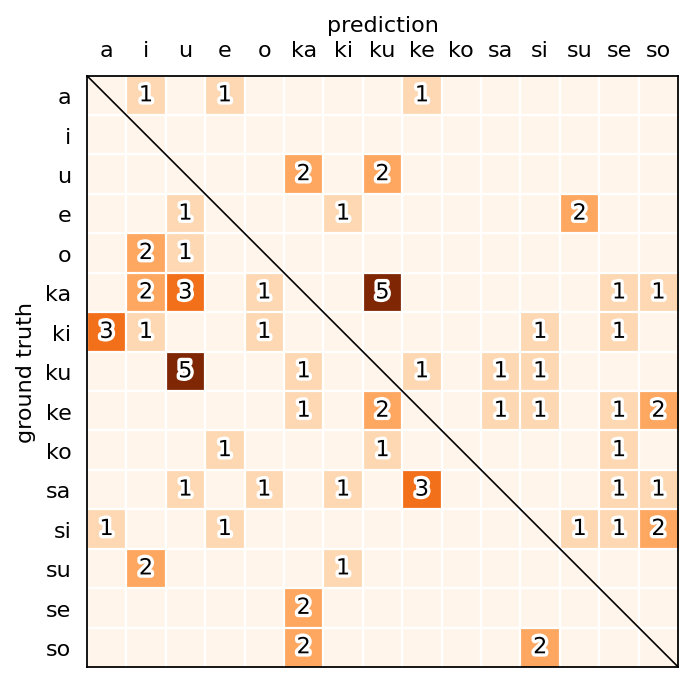

In [22]:
df = pd.DataFrame({'ground_truth':test_id, 'prediction':test_pred[9]})

num_label_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
kana_list = ['a', 'i', 'u', 'e', 'o',
             'ka', 'ki', 'ku', 'ke', 'ko',
             'sa', 'si', 'su', 'se', 'so']

# クロス集計表
dfc = pd.crosstab(index=df['ground_truth'], columns=df['prediction']) 
#display(dfc)

for i in dfc.index.values :
  dfc.at[i,i] = 0.0

# ヒートマップ的に出力
plt.figure(dpi=160)

plt.imshow(dfc,interpolation='nearest',cmap='Oranges')
plt.plot([0,0],[14,14])

n = len(dfc.columns) # 項目数
plt.gca().set_xticks(range(n))
# plt.gca().set_xticklabels(dfc.columns)
plt.xticks(num_label_list, kana_list)
plt.gca().set_yticks(range(n))
# plt.gca().set_yticklabels(dfc.columns)
plt.yticks(num_label_list, kana_list)
plt.tick_params(axis='x', which='both', direction=None, 
                top=True, bottom=False, labeltop=True, labelbottom=False)
plt.tick_params(axis='both', which='both', top=False, left=False )

# グリッドに関する設定
plt.gca().set_xticks(np.arange(-0.5, n-1), minor=True);
plt.gca().set_yticks(np.arange(-0.5, n-1), minor=True);
plt.grid( which='minor', color='white', linewidth=1)

plt.gca().xaxis.set_label_position('top') 
plt.xlabel('prediction')
plt.ylabel('ground truth')

plt.plot([-0.5,n-0.5],[-0.5,n-0.5],color='black',linewidth=0.75)

# 相関係数を表示（文字に縁取り付き）
tp = dict(horizontalalignment='center',verticalalignment='center')
ep = [pe.Stroke(linewidth=3, foreground='white'),pe.Normal()]
for y,i in enumerate(dfc.index.values) :
  for x,c in enumerate(dfc.columns.values) :
    if x != y :
      if dfc.at[i,c] !=  0:
        t = plt.text(x, y, f'{dfc.at[i,c]}',**tp)
        t.set_path_effects(ep) 

In [15]:
pd.test()

ImportError: Need hypothesis>=3.58 to run tests

train_dataの正解ラベルの分布を確認する

In [29]:
train_id = np.dot(y_train, vec_trans_id.T)
print(train_id.shape)
print(train_id)
print(type(train_id))

(1831,)
[14  0 14 ...  8  4  2]
<class 'numpy.ndarray'>


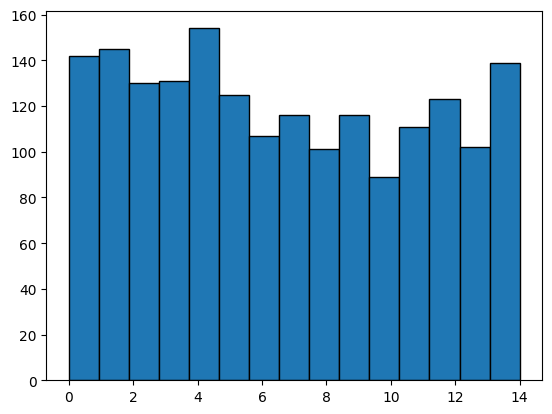

In [30]:
# ヒストグラム
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(train_id, bins=15, histtype='barstacked', ec='black')
plt.show()

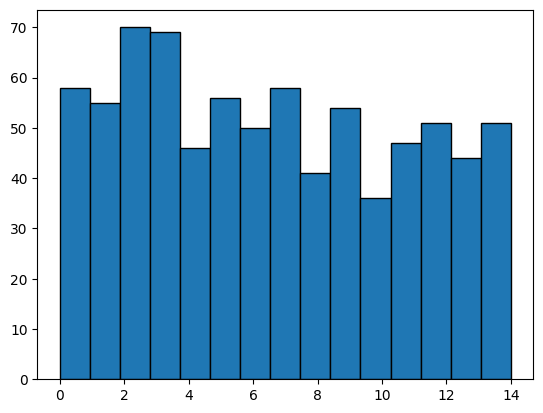

In [31]:
# ヒストグラム
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(test_id, bins=15, histtype='barstacked', ec='black')
plt.show()